Mounting the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Defining the dataset path

In [2]:
dataset_path = "/content/drive/MyDrive/dataset/"

Importing the required libraries

In [10]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from PIL import Image
import pandas as pd
from sklearn.metrics import classification_report

Visualising Class Distribution

<ipython-input-11-a2d79d55671c>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_series.index, y=counts_series.values, palette='cividis')


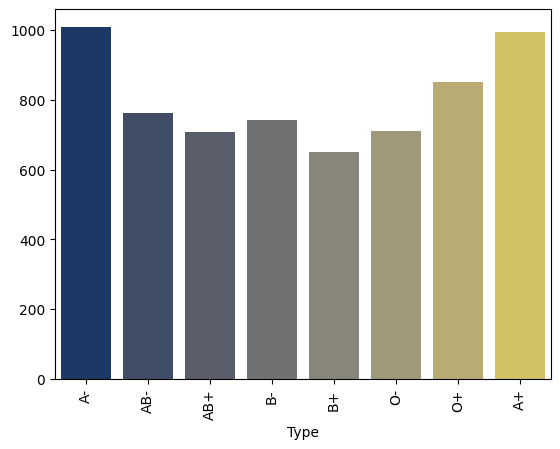

In [11]:
# Get class names (folder names)
class_names = os.listdir(dataset_path)

# Count images in each class folder
counts = {}
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    counts[class_name] = len(os.listdir(class_path))

# Convert counts to a pandas Series for easier plotting
import pandas as pd
counts_series = pd.Series(counts)

# Create bar plot
sns.barplot(x=counts_series.index, y=counts_series.values, palette='cividis')
plt.xlabel('Type')
plt.xticks(rotation=90)
plt.show()

Load pre-trained MobileNet Model

In [12]:
# Load MobileNetV2 without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all convolutional layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Print model summary
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 412,800 (1.57 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

Add Custom layers for classification

In [20]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

Output layer for 8 classes (A-, A+, AB-, AB+, B-, B+, O-, O+)

In [21]:
output = Dense(8, activation='softmax')(x)

Create new Model

In [22]:
model = Model(inputs=base_model.input, outputs=output)

Compile the Model

In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Show Model Summary

In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 12,810,952 (48.87 MB)

 Trainable params: 10,965,768 (41.83 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

Data Preprocessing and Augmentation

In [27]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)  # 20% validation

# Load dataset from Google Drive directory
train_generator = train_datagen.flow_from_directory(dataset_path,
                                                    target_size=(128, 128),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(dataset_path,
                                                         target_size=(128, 128),
                                                         batch_size=32,
                                                         class_mode='categorical',
                                                         subset='validation')

Found 5147 images belonging to 8 classes.
Found 1283 images belonging to 8 classes.


Training the Model

In [30]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(validation_generator))

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2506 - loss: 3.9738

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 1042s 6s/step - accuracy: 0.2509 - loss: 3.9662 - val_accuracy: 0.3718 - val_loss: 1.5851
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 58s 312ms/step - accuracy: 0.3361 - loss: 1.7480 - val_accuracy: 0.4201 - val_loss: 1.5071
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 319ms/step - accuracy: 0.4129 - loss: 1.5725 - val_accuracy: 0.4567 - val_loss: 1.4021
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 321ms/step - accuracy: 0.4420 - loss: 1.4194 - val_accuracy: 0.4981 - val_loss: 1.2510
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 52s 323ms/step - accuracy: 0.4649 - loss: 1.3513 - val_accuracy: 0.5292 - val_loss: 1.1624
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 51s 317ms/step - accuracy: 0.4980 - loss: 1.2690 - val_accuracy: 0.5799 - val_loss: 1.0948
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 52s 321ms/step - accuracy: 0.5343 - loss: 1.1930 - val_accuracy: 0.5970 - val_loss: 1.0535
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 388ms/step - accuracy: 0.5743 - loss: 1.1295 - val_

Visualising the Performance

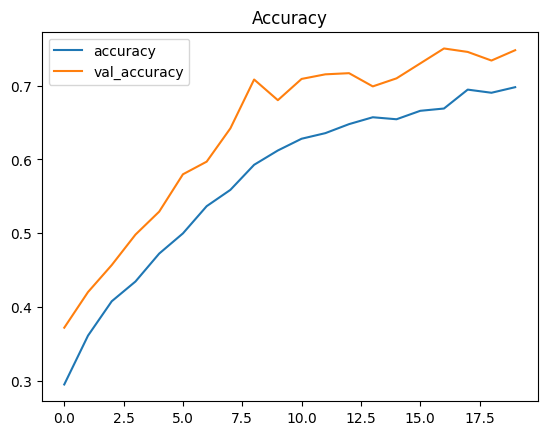

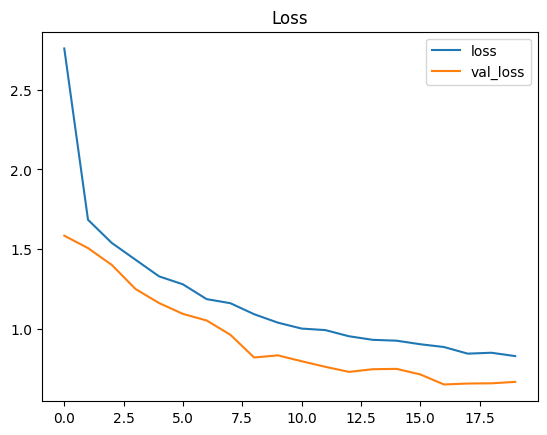

Test Loss: 0.65927
Test Accuracy: 74.90%
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step
              precision    recall  f1-score   support

          A+       0.15      0.16      0.15       199
          A-       0.18      0.19      0.18       201
         AB+       0.11      0.10      0.11       141
         AB-       0.17      0.20      0.19       152
          B+       0.07      0.06      0.06       130
          B-       0.14      0.17      0.15       148
          O+       0.09      0.06      0.07       170
          O-       0.07      0.07      0.07       142

    accuracy                           0.13      1283
   macro avg       0.12      0.13      0.12      1283
weighted avg       0.13      0.13      0.13      1283



In [32]:
# Plot training history: accuracy
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

# Plot training history: loss
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

# Evaluate the model on test data
results = model.evaluate(validation_generator, verbose=0)
print(f"Test Loss: {results[0]:.5f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")

# Predict labels for test data
pred = model.predict(validation_generator)
pred = np.argmax(pred, axis=1)

# Map predicted labels
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Get true labels for validation data
y_test = []
for i in range(len(validation_generator)):
    _, batch_labels = validation_generator[i]  # Get true labels from the generator
    y_test.extend(np.argmax(batch_labels, axis=1))  # Convert one-hot encoded labels to class indices

# Convert class indices to class names
y_test = [labels[k] for k in y_test]

# Compare predicted labels with true labels and print classification report
print(classification_report(y_test, pred))

Evaluating the Model

In [33]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.7470 - loss: 0.6641
Validation Accuracy: 74.67%


Saving the Model

In [34]:
model_save_path = "/content/drive/MyDrive/fingerprint_blood_group_classifier_MobileNetV2.h5"
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/fingerprint_blood_group_classifier_MobileNetV2.h5


Mounting the Drive once again

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Displaying the Sample Image

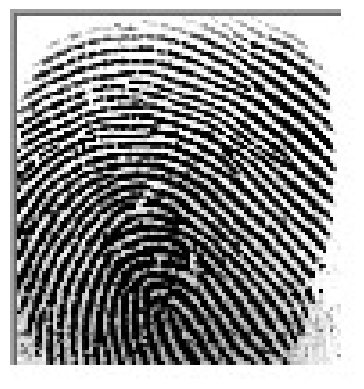

In [47]:
img = Image.open("/content/drive/MyDrive/testdata/fpanone.jpg").convert("RGB")
plt.imshow(img)
plt.axis('off')
plt.show()

Predicting the Blood Group of the Sample Image

In [48]:
def predict_image(img_path, model, train_gen):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(128, 128), color_mode="rgb")
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)

    # Get class labels
    class_labels = {v: k for k, v in train_gen.class_indices.items()}  # Reverse mapping
    predicted_blood_group = class_labels.get(predicted_class_index, "Unknown")

    print(f"Raw Predictions: {predictions}")  # Debugging output
    print(f"Predicted Class Index: {predicted_class_index}")
    print(f"Predicted Blood Group: {predicted_blood_group}")

    return predicted_blood_group

# Example usage
test_image_path = "/content/drive/MyDrive/testdata/fpanone.jpg"
predicted_blood_group = predict_image(test_image_path, model, train_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Raw Predictions: [[1.2916593e-04 6.7380619e-01 9.2271435e-08 1.5432551e-04 1.9785912e-06
  8.9811571e-02 2.3609124e-01 5.3986878e-06]]
Predicted Class Index: 1
Predicted Blood Group: A-


Visualising the Overall Performance

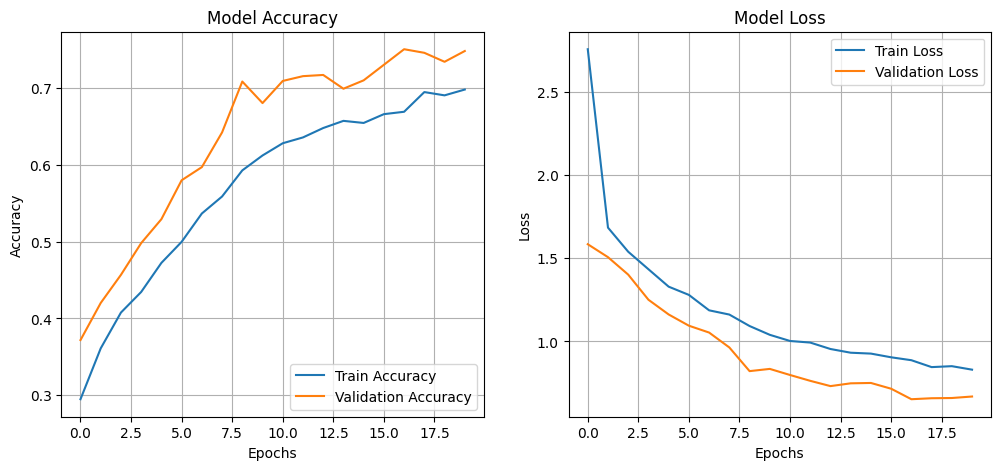

In [39]:
def plot_training(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

# Call the function
plot_training(history)